<a href="https://colab.research.google.com/github/developerdatascience/AMEX_Default_Prediction/blob/main/Recommended_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The main families of methods for RecSys are:

---



---



1.Simple Recommender: recommend the most popular items for each user.

2.Collaborative filtering: This method makes automatic predictions(filtering) about the interest of the users by collecting preferences or
taste information from many users(collaborating). The underlying assumption of the collaborative filtering approach is that if a person A
has the same opinion as a person B on the set of items, A is more likely to have B's opinion for a given item than that of a randomly chosen person

3.Content based filtering: This method uses only information about the description and attributes of the items users has previously consumed to model users's preferences. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past (or is examining in the present). In particular, various candidate items are compared with itesms previously rated by the user and best-matching items are recommended.

4.Hybrid methods: Recent research has demonstrated that a hybrid approach, combining collaborative filtering and content based filtering could be more effective that pure approaches in some cases. These methods can also be used to overcome some of the common problems in the recommender systems such as cold start and the sparsity problems.

In [3]:
import warnings
warnings.filterwarnings('ignore')

# DATA

We will use the small version of MovieLens datasets that contains 100000 rating and 3600 tag applications applied to 9000 movies by 600 users, and last update on it was in 2018

for more information about bigger versions: https://grouplens.org/datasets/movieslens/

In [4]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2023-04-10 08:03:10--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  4.60MB/s    in 0.2s    

2023-04-10 08:03:10 (4.60 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


This dataset consists of the following files:

movies.csv: This file contains genre information on movies featured in the dataset

tags.csv: Contains tages that are user-generated metadata about the movies. Each tag is typically a single word or short phrases. The meaning , value, and purpose of a particular tag is determined by each user.

links.csv: This file contains the TMBD and IMDB IDs of all the moves featured in the dataset.

ratings.csv: Each line of this file after the header row represents one rating of one movie by one user. Ratings are made on a 5-star scale,with half star increments.

In [5]:
import pandas as pd

movies = pd.read_csv("ml-latest-small/movies.csv", header=0)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movies.shape

(9742, 3)

In [7]:
ratings = pd.read_csv("ml-latest-small/ratings.csv")
print(ratings.head(5))
print(ratings.shape)

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
(100836, 4)


# Evaluation

We evaluate on the subset of data called Test data, in our case we can take 20% random data sample as test OR for more robust evaluation approach could be to split train and test sets by a reference date, where the train set is composed by all the movies before that date, and the test set are movies after that date to better simulate how the recsys would perform in the production predicting "future" users interaction

In [8]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [9]:
import re

def extract_year(title):
  match = re.search(r'\((.*?)\)', title)
  if match:
    return match.group(len(match.groups()))
  return '1999'

movies['year'] = movies['title'].apply(lambda x: extract_year(x))
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [10]:
threshold_date = '2015'
ids = movies[movies['year'] < threshold_date]['movieId'].values

training_data = ratings[ratings['movieId'].isin(ids)]
print(f'Training data size: {training_data.shape}')
testing_data = ratings[~ratings['movieId'].isin(ids)]
print(f"Testing data size: {testing_data.shape}")


Training data size: (91637, 4)
Testing data size: (9199, 4)


For evaluation we will work with Top-K metrics, which evaluates the accuracy of the top recomendations provided to a users, comparing to the items the users has actually interacted in the test set.

The Top-k accuracy metric choosen are Recall@K and Precision@K:

Recall@K = (Relevant_Items_Reccommended in top-k)/(Relevant_Items)

Precison@K = (Relevant_Items_Recommended in top-k)/(n_items_Recommended)


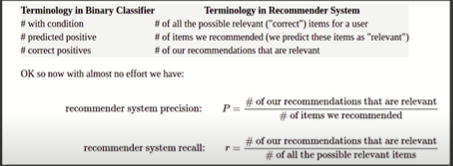

Let's understand the definitions of recall@k and precision@k, assume we are providing 5 recommendations in this order -1 0 1 0 1, where 1 represets relevant and 0 irrelevant. So the precision@k at different values of k will be precision@3 is 2/3, precision@4 is 2/4 and precision@5 is 3/5. The recall@k would be , recall@3 is 2/3, recall@4 is 2/3 and recall@5 is 3/3

In [11]:
def get_favorites_movies(user_id, ratings_df):
  favorites = ratings_df[(ratings_df['userId'] == user_id) & (ratings_df['rating'] >= 3.5)].sort_values(by='rating', ascending=False)['movieId']
  return set(favorites if type(favorites) == pd.Series else [favorites])

In [12]:
class ModelEvaluator:
  def __init__(self, training_data, testing_data, threshold=3.5):
    self.training_data = training_data
    self.testing_data = testing_data
    self.threshold = threshold

  
  def evaluate_model_for_user(self, model, user_id):
    #getting the items in test set
    favorites_in_test = get_favorites_movies(user_id, self.testing_data)

    #getting a ranked recommendations list from a model for a given user (movieId, predicted_rating)
    person_recs_df = model.recommend_items(user_id, 
                                          items_to_ignore=get_favorites_movies(user_id, self.training_data))
    
    #get only movies with predicted rating >=3.5
    person_recs_df = person_recs_df[person_recs_df['predicted_rating'] >= self.threshold].sort_values(by='predicted_rating', ascending=False)
    true_relevant = person_recs_df[person_recs_df['movieId'].isin(favorites_in_test)].shape[0]

    top_5_recommended = person_recs_df.head(5)
    top_10_recommended= person_recs_df.head(10)

    # Number of relevant and recommended items in top k
    hits_at_5_count = top_5_recommended[top_5_recommended['movieId'].isin(favorites_in_test)].shape[0]
    hits_at_10_count = top_10_recommended[top_10_recommended['movieId'].isin(favorites_in_test)].shape[0]

    precision_at_5 = hits_at_5_count / top_5_recommended.shape[0] if top_5_recommended.shape[0] != 0 else 1
    recall_at_5 = hits_at_5_count / true_relevant if true_relevant != 0 else 1

    precision_at_10 = hits_at_10_count / top_5_recommended.shape[0] if top_10_recommended.shape[0] != 0 else 1
    recall_at_10 = hits_at_10_count / true_relevant if true_relevant != 0 else 1

    person_metrics = {
        'hits@5_count': hits_at_5_count,
        "hits@10_count": hits_at_10_count,
        'recommended@5_count': top_5_recommended.shape[0],
        'recommended@10_count': top_10_recommended.shape[0],
        'relevants': true_relevant,
        'recall@5': recall_at_5,
        'recall@10': recall_at_10,
        'precision@5': precision_at_5,
        'precision@10': precision_at_10
    }

    return person_metrics


  def evaluate_model(self, model):
    #print('Runnning evaluation for user)
    user_metrics = []
    user_ids = list(set(self.testing_data['userId'].values))
    for idx, user_id in enumerate(user_ids):
      metrics = self.evaluate_model_for_user(model, user_id)
      metrics['user_id'] = user_id
      user_metrics.append(metrics)
    print("%d users processed" % idx)

    detailed_results_df = pd.DataFrame(user_metrics) \
                          .sort_values('hits@5_count', ascending=False)
    
    global_recall_at_5 = detailed_results_df['hits@5_count'].sum()/float(detailed_results_df['relevants'].sum())
    global_recall_at_10 = detailed_results_df['hits@10_count'].sum()/float(detailed_results_df['relevants'].sum())

    global_precision_at_5 = detailed_results_df['hits@5_count'].sum()/float(detailed_results_df['recommended@5_count'].sum())
    global_precision_at_10 = detailed_results_df['hits@10_count'].sum()/float(detailed_results_df['recommended@10_count'].sum())

    global_metrics = {
        'modelName': model.get_model_name(),
        'recall@5': global_recall_at_5,
        'recall@10': global_recall_at_10,
        'precision@5': global_precision_at_5,
        'precision@10': global_precision_at_10

    }

    return global_metrics, detailed_results_df

      


In [13]:
model_evaluator = ModelEvaluator(training_data, testing_data)

# Popularity Recommender

A common (and usually hard-to-beat) baseline approach is the Popularity model. This model is not personalized-it simply recommends to a users the most popular items that the user has not previously consumed. As the popularity accounts for the "wisdom of the crowds", it usally provides good recommendations, generally interesting for the most people.

However, using a rating as a metric has a few caveats:

For the one, it doest not take into considerations the popularity of a movie. Therefore, a movie with a rating of 9 from 10 voters will be considered better than a movie with a rating of 8.9 from 10,000 voters.

For example, imagine you want to order chinese food, you have a couple of options, one restaurant  has a 5-star rating by only 5 people while the other restaurant has 4.5 ratings y 1000 people. Which restaurant would you prefer? The second one, right?

Taking these shortcomings  into consideration , you must come up with a weighted rating that takes into account the average rating and the number of votes it has accumulated.

(v/(v+m)*R) + (m/(m+v) * C)

In the above equation,



*   v is the number of ratings for the movie
*   m is the minimum rating required to be listed in the chart


*   R is the average rating of the movie
*   C is the mean ratings across the whole movies





In [14]:
popularity = ratings.groupby('movieId').agg({'rating': ['mean', 'count']}).reset_index()
popularity.columns= ['movieId', 'ratings_mean', 'ratings_count']
popularity.sort_values(by='ratings_mean', ascending=False)

,movieId,ratings_mean,ratings_count
7638,88448,5.0,1
8089,100556,5.0,1
9065,143031,5.0,1
9076,143511,5.0,1
9078,143559,5.0,1
...,...,...,...
9253,157172,0.5,1
7536,85334,0.5,1
6486,53453,0.5,1
5200,8494,0.5,1


In [15]:
class PopularityRecommender:

  MODEL_NAME = 'Popularity'

  def __init__(self, popularities_df):
    self.popularities_df = popularities_df

  
  def get_model_name(self):
    return self.MODEL_NAME
  
  def weighted_rating(self, x, m, C):
    v = x['ratings_count']
    R = x['ratings_mean']

    # Calculation based on IMDB formula

    return (v/(v+m) * R) + (m/(m+v) * C)
  

  def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
    C = self.popularities_df['ratings_mean'].mean()

    self.popularities_df['predicted_rating'] = self.popularities_df.apply(lambda x: self.weighted_rating(x, 3.5, C), axis=1)

    recommendations_df = self.popularities_df[~self.popularities_df['movieId'].isin(items_to_ignore)] \
                        .sort_values('predicted_rating', ascending=False) \
                        .head(topn)
    
    return recommendations_df


popularity_model = PopularityRecommender(popularity)


In [16]:
print('Evaluating Popularity recommendation model....')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\Global metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model....
571 users processed
\Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.44, 'recall@10': 1.0, 'precision@5': 0.0038461538461538464, 'precision@10': 0.004370629370629371}


,hits@5_count,hits@10_count,recommended@5_count,recommended@10_count,relevants,recall@5,recall@10,precision@5,precision@10,user_id
443,2,3,5,10,3,0.666667,1.0,0.4,0.6,474
23,1,1,5,10,1,1.000000,1.0,0.2,0.2,25
316,1,1,5,10,1,1.000000,1.0,0.2,0.2,338
197,1,1,5,10,1,1.000000,1.0,0.2,0.2,209
390,1,2,5,10,2,0.500000,1.0,0.2,0.4,414
220,1,1,5,10,1,1.000000,1.0,0.2,0.2,233
200,1,1,5,10,1,1.000000,1.0,0.2,0.2,212
297,1,1,5,10,1,1.000000,1.0,0.2,0.2,318
438,1,1,5,10,1,1.000000,1.0,0.2,0.2,469
16,1,1,5,10,1,1.000000,1.0,0.2,0.2,18


In [17]:
popularity_model.recommend_items(5)

,movieId,ratings_mean,ratings_count,predicted_rating
277,318,4.429022,317,4.416283
9600,177593,4.750000,8,4.297267
840,1104,4.475000,20,4.294407
659,858,4.289062,192,4.270683
796,1041,4.590909,11,4.270246
2224,2959,4.272936,218,4.256969
882,1178,4.541667,12,4.252811
2579,3451,4.545455,11,4.235763
921,1221,4.259690,129,4.233348
602,750,4.268041,97,4.233021


In [18]:
ids = popularity_model.recommend_items(10)['movieId'].values
movies[movies['movieId'].isin(ids)]['title'].values

array(['Shawshank Redemption, The (1994)',
       'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)',
       'Godfather, The (1972)', 'Secrets & Lies (1996)',
       'Streetcar Named Desire, A (1951)', 'Paths of Glory (1957)',
       'Godfather: Part II, The (1974)', 'Fight Club (1999)',
       "Guess Who's Coming to Dinner (1967)",
       'Three Billboards Outside Ebbing, Missouri (2017)'], dtype=object)

# Content Based Filtering

Content-based filtering approaches leverage description or attributes from items the user has interacted to recommend similar items. It depends only on the user previous choices, making this method robust to avoid the cold-start problem. For textual items, like articles, news and books, it is simple to use the raw text to build item profiles and user profiles using TF-IDF

# Use Genres as content

In [19]:
# get all the unique genres

genres = list(set([x for genres in movies['genres'].values for x in genres.split('|')]))
genres

['Horror',
 'Romance',
 'Documentary',
 'Children',
 'Drama',
 'Musical',
 'Western',
 'Comedy',
 'Film-Noir',
 'IMAX',
 'War',
 'Thriller',
 'Animation',
 'Action',
 'Crime',
 'Sci-Fi',
 'Adventure',
 'Mystery',
 '(no genres listed)',
 'Fantasy']

In [20]:
expanded_movies_df = movies.copy()
for g in genres:
  expanded_movies_df[g] = [ 0 if not g in genres.split('|') else 1 for genres in movies['genres'].values]

In [21]:
expanded_movies_df.head()

,movieId,title,genres,year,Horror,Romance,Documentary,Children,Drama,Musical,...,War,Thriller,Animation,Action,Crime,Sci-Fi,Adventure,Mystery,(no genres listed),Fantasy
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


To model the user profile, we take all the item profiles the user has interacted and average them. The avergae is weighted by user ratings

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def normalize(value, old_max, old_min, new_max=5.0, new_min=0.0):
  old_range = (old_max - old_min)
  new_range = (new_max - new_min)
  return (((value - old_min) * new_range) / old_range) + new_min

In [33]:
class ContentBasedRecommender:
  MODEL_NAME = 'Content-Based'

  def __init__(self, items_df, training_data, testing_data):
    self.items_df = items_df
    self.features_names = items_df.columns[4:]
    self.training_data = training_data
    self.testing_data = testing_data
  
  def get_model_name(self):
    return self.MODEL_NAME

  
  def get_item_profile(self, item_id):
    item_profile = self.items_df[self.items['movieId']== item_id][self.features_name]
    return item_profile

  def get_items_profiles(self, ids):
    item_profiles = self.items_df[self.items_df['movieId'].isin(ids)][self.features_names].values
    return item_profiles
  
  def build_users_profile(self, user_id):
    user_df = self.training_data[self.training_data['userId'] == user_id]
    user_items_profiles = self.get_items_profiles(user_df['movieId'].values)
  
    user_items_ratings = np.array(user_df['rating'].values).reshape(-1, 1)
    user_profile = np.sum(np.multiply(user_items_profiles, user_items_ratings), axis=0) / np.sum(user_items_ratings)
    return user_profile
  
  def get_similar_items_to_user_profile(self, user_id, topn=1000):
    user_profile = self.build_users_profile(user_id).reshape(1, -1)
    # Computes the cosine similarity between the user profile and all the item profiles
    cosine_similarities = cosine_similarity(user_profile, self.items_df[self.features_names].values)
    # Get the top similar items
    similar_indices = cosine_similarities.argsort().flatten()[-topn:]
    # sort the similar items by similarity
    similar_items = sorted([(self.items_df.loc[i, 'movieId'], cosine_similarities[0, i]) for i in similar_indices], key=lambda x: -x[1])
    return similar_items
  
  def recommend_items(self, user_id, items_to_ignore=[], topn=10):
    similar_items = self.get_similar_items_to_user_profile(user_id)
    similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
    recommendations_df = pd.DataFrame(similar_items_filtered, columns=['movieId', 'predicted_rating']) \
                          .head(topn)
    
    recommendations_df['predicted_rating'] = recommendations_df['predicted_rating'].apply(lambda x: normalize(x, 1.0, 0.0))
    return recommendations_df


In [34]:
content_based_recommender_model = ContentBasedRecommender(expanded_movies_df, training_data, testing_data)

In [35]:
print('Evaluating Content-Based Filtering model....')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model....
571 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.41379310344827586, 'recall@10': 1.0, 'precision@5': 0.004195804195804196, 'precision@10': 0.00506993006993007}


,hits@5_count,hits@10_count,recommended@5_count,recommended@10_count,relevants,recall@5,recall@10,precision@5,precision@10,user_id
571,1,1,5,10,1,1.000000,1.0,0.2,0.2,610
15,1,1,5,10,1,1.000000,1.0,0.2,0.2,17
100,1,1,5,10,1,1.000000,1.0,0.2,0.2,103
259,1,1,5,10,1,1.000000,1.0,0.2,0.2,274
119,1,1,5,10,1,1.000000,1.0,0.2,0.2,123
237,1,1,5,10,1,1.000000,1.0,0.2,0.2,252
406,1,1,5,10,1,1.000000,1.0,0.2,0.2,432
127,1,1,5,10,1,1.000000,1.0,0.2,0.2,131
233,1,3,5,10,3,0.333333,1.0,0.2,0.6,248
232,1,1,5,10,1,1.000000,1.0,0.2,0.2,247


# Use tags as content

The quality of your recommender would be increased with the usage of better metadata and by capturing more of the finer details.That is precisely what you re going todo in this section by using movies tags(keywords, cast, geners) as content

We will simply join all the required tags for a movie by a space. This is the final preprocessing step, and the output of this function will be fed into the word vector model

byt note that:


1.   Removing the spaces between words is an important preprocessing step.It is done so that your vectorizer doesn't count the Johnny of 'Johnny Depp' and 'Johnny Galecki' as the same. After this processing step, the aforementioned actors will be represented as 'johnnydepp' and 'johnnyhgalecki' and wikk be distinct to your vectorizer.

2.   Need to convert all letters to small



In [36]:
tags = pd.read_csv('ml-latest-small/tags.csv', header=0)
tags.head(10)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
5,2,89774,Tom Hardy,1445715205
6,2,106782,drugs,1445715054
7,2,106782,Leonardo DiCaprio,1445715051
8,2,106782,Martin Scorsese,1445715056
9,7,48516,way too long,1169687325


In [37]:
def check_name(x):
  words = x.split()
  return all(x[0].isupper() and x[1].islower() for x in words if len(x) > 1)

def clean(x):
  if x.istitle() or check_name(x):
    return x.replace(" ", "").lower()
  else:
    return x.lower().strip()

In [38]:
tags['tag'] = tags['tag'].apply(lambda x: clean(x))
tags.head(10)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,boxing story,1445715207
4,2,89774,mma,1445715200
5,2,89774,tomhardy,1445715205
6,2,106782,drugs,1445715054
7,2,106782,leonardodicaprio,1445715051
8,2,106782,martinscorsese,1445715056
9,7,48516,way too long,1169687325


In [39]:
expended_movies_df = movies.copy()

movies_ids = expended_movies_df['movieId'].values.tolist()
expended_movies_df['soup'] = [" ".join(tags[tags['movieId']==id]['tag'].values.tolist()) for id in movies_ids]

In [40]:
expended_movies_df.head(10)

,movieId,title,genres,year,soup
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,pixar pixar fun
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,fantasy magic board game robinwilliams game
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,moldy old
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,
4,5,Father of the Bride Part II (1995),Comedy,1995,pregnancy remake
5,6,Heat (1995),Action|Crime|Thriller,1995,
6,7,Sabrina (1995),Comedy|Romance,1995,remake
7,8,Tom and Huck (1995),Adventure|Children,1995,
8,9,Sudden Death (1995),Action,1995,
9,10,GoldenEye (1995),Action|Adventure|Thriller,1995,


In [41]:
expended_movies_df.loc[8, 'soup']

''

In [42]:
expended_movies_df[expended_movies_df['soup'] != ''].shape

(1572, 5)

In [43]:
def fill_empty_tag(x):
  if x['soup'] =='':
    return " ".join(x['genres'].lower().split('|'))
  return x['soup']

  expended_movies_df['soup'] = expended_movies_df.apply(lambda x: fill_empty_tag(x), axis=1)
  expended_movies_df.head(10)

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(expended_movies_df['soup'])
count_matrix.shape

(9742, 1578)

In [45]:
class ContentBasedRecommender:

  MODEL_NAME = 'Content-Based'

  def __init__(self, items_ids, items_matrix, training_data, testing_data):
    self.items_ids = items_ids
    self.items_matrix = items_matrix
    self.training_data = training_data
    self.testing_data = testing_data

  
  def get_model_name(self):
    return self.MODEL_NAME
  
  def get_item_profile(self, item_id):
    idx = self.items_ids.index(item_id)
    return self.items_matrix[idx].toarray().reshape(-1)
  
  def get_items_profiles(self, ids):
    items_profiles = np.array([self.get_item_profile(x) for x in ids])
    return items_profiles
  
  def build_users_profile(self, user_id):
    user_df = self.training_data[self.training_data['userId'] == user_id]
    user_items_profiles = self.get_items_profiles(user_df['movieId'].values)

    user_items_ratings = np.array(user_df['rating'].values).reshape(-1, 1)
    user_profile= np.sum(np.multiply(user_items_profiles, user_items_ratings), axis=0) / np.sum(user_items_ratings)
    return user_profile
  
  def get_similar_items_to_user_profile(self, user_id, topn=1000):
    user_profile = self.build_users_profile(user_id).reshape(1, -1)

    # computes the cosine similarity between the user profile and all item profiles
    cosine_similarities = cosine_similarity(user_profile, self.items_matrix.toarray())
    # get the top similar items
    similar_indices = cosine_similarities.argsort().flatten()[-topn:]
    # Sort the similar items by similarity

    similar_items = sorted([(self.items_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
    return similar_items

  
  def recommend_items(self, user_id, items_to_ignore=[], topn=10):
    similar_items = self.get_similar_items_to_user_profile(user_id)
    similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))

    recommendations_df = pd.DataFrame(similar_items_filtered, columns=['movieId', 'predicted_rating']) \
                        .head(topn)
    
    recommendations_df['predicted_rating'] = recommendations_df['predicted_rating'].apply(lambda x: normalize(x, 1.0, 0.0))
    return recommendations_df


content_based_recommender_model = ContentBasedRecommender(expended_movies_df['movieId'].values.tolist(), count_matrix, training_data, testing_data)


In [46]:
print('Evaluating Content-Based Filtering model....')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model....
571 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 1.0, 'recall@10': 1.0, 'precision@5': 0.025, 'precision@10': 0.025}


,hits@5_count,hits@10_count,recommended@5_count,recommended@10_count,relevants,recall@5,recall@10,precision@5,precision@10,user_id
18,1,1,5,5,1,1.0,1.0,0.2,0.2,20
393,0,0,0,0,0,1.0,1.0,1.0,1.0,417
377,0,0,0,0,0,1.0,1.0,1.0,1.0,400
378,0,0,0,0,0,1.0,1.0,1.0,1.0,401
379,0,0,0,0,0,1.0,1.0,1.0,1.0,402
380,0,0,0,0,0,1.0,1.0,1.0,1.0,403
381,0,0,1,1,0,1.0,1.0,0.0,0.0,404
382,0,0,0,0,0,1.0,1.0,1.0,1.0,405
383,0,0,0,0,0,1.0,1.0,1.0,1.0,407
384,0,0,0,0,0,1.0,1.0,1.0,1.0,408


You can make execution faster by foe example put user ids as dataframe index or change the dataframe

Issues in recommender System:

1. Cold Start Problem

Whenever a new user enters a recommender system, the question arises of what to recommend him/her and on what basis as previous data is not available and similarity calculation could not be performed. One solution to this problem is to make the new users enter a small introduction form containing basic information about the person's interest, hobbies, occupations, and creating a basic user profile and then recommending items to the new user. This would solve the cold start problem to a great extent

2. Data Sparsity Problem:

The major issue in a recommender system is the unavailability of appropriate data which is the main requirement for the recommendation process. Many users don't bother to review items they bought. As a result, the user-item rating matrix has many sparse entries which degrade the performance of the similarity calculation algorithm. So one solution is to predict sparse entries and many researchers have given algorithms to predict these ratings such as a negative weighted one slope algorithm.


3. Changing Dataset:


With the increase in the amount of data every day, there is an increase in the inclusion of data in the previous dataset of the recommender system which may alter the overall structure and composition of the dataset. Both new users and new items needed to get included in the dataset. So this change needed to be accommodated in the dataset.
4. Scalability Problem:
In a practical scenario, it is not always possible to find similar users and similar items every time and prevent the system from failure. So building a scalable recommender system is a major concern.



5. Shilling attack

Shilling attack is defined as the process of inclusion of fake profiles and biased reviews and ratings to bias the entire recommendation process.
A malicious attacker may inject these profiles so as to increase/decrease recommending frequency of target items.


# Collaborative Filtering model


Collaborative Filtering (CF) has two main implementation strategies:

• Memory-based. This approach uses the memory of previous users interactions to compute users similarities based on items they’ve interacted (user based approach) or compute items similarities based on the users that have interacted with them (item-based approach)
A typical example of this approach is User Neighbourhood-based CF, in which the top-N similar users (usually computed using Pearson correlation) for a user are selected and used to recommend items those similar users liked, but the current user have not interacted yet

• Model-based: This approach, models are developed using different machine learning algorithms to recommend items to users. There are many model-based CF algorithms, like neural networks, bayesian networks, clustering models, and latent factor models such as Singular Value Decomposition (SD) and, probabilistic latent semantic analysis.



In [49]:
# Creating a spares pivot table with users in rows and items in columns
users_items_pivot_matrix_df = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
users_items_pivot_matrix_df.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,4.0,5.0,3.0,5.0,4.0,4.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [50]:
from scipy.sparse.linalg import svds

# The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
# Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [51]:
U.shape

(610, 15)

In [52]:
Vt.shape

(15, 9724)

In [53]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

The resulting matrix is not sparse anymore. It was generated predictions for the items the user have not yet interaction, which we will exploit for recommendations:

In [54]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
all_user_predicted_ratings

array([[ 2.48313562e+00,  1.35885909e+00,  1.10637440e+00, ...,
        -3.49319264e-03, -3.49319264e-03, -2.47602496e-02],
       [ 4.22544294e-02,  1.03805400e-02,  3.20579362e-02, ...,
         9.95659214e-03,  9.95659214e-03,  1.31613972e-02],
       [ 1.38016774e-02,  2.86395855e-02,  3.19043736e-02, ...,
         9.42462913e-04,  9.42462913e-04, -1.75137511e-03],
       ...,
       [ 2.17103278e+00,  1.92389820e+00,  1.71015130e+00, ...,
        -5.55603096e-02, -5.55603096e-02, -9.01278061e-03],
       [ 8.38486877e-01,  6.37344297e-01,  3.19950208e-01, ...,
         4.27295325e-04,  4.27295325e-04,  1.65256080e-03],
       [ 5.86830717e+00, -1.00804430e-01, -1.49624909e+00, ...,
         2.66883644e-02,  2.66883644e-02,  8.02635842e-02]])

Convert the reconstrcuted matrix back to a Pandas dataframe

In [55]:
preds_df = pd.DataFrame(all_user_predicted_ratings, columns=users_items_pivot_matrix_df.columns, index=users_items_pivot_matrix_df.index)

In [56]:
preds_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,2.483136,1.358859,1.106374,-0.025920,0.174511,1.614364,0.167845,0.043874,0.206104,1.823636,...,-0.003493,-0.002994,-0.003992,-0.003992,-0.003493,-0.003992,-0.003493,-0.003493,-0.003493,-0.024760
2,0.042254,0.010381,0.032058,0.002357,0.030592,-0.001568,0.013115,0.000889,0.019802,-0.139452,...,0.009957,0.008534,0.011379,0.011379,0.009957,0.011379,0.009957,0.009957,0.009957,0.013161
3,0.013802,0.028640,0.031904,-0.002689,-0.022141,0.064227,0.000262,0.009224,0.012006,0.038832,...,0.000942,0.000808,0.001077,0.001077,0.000942,0.001077,0.000942,0.000942,0.000942,-0.001751
4,2.082146,0.162685,0.102233,0.053761,0.146481,0.454800,0.304220,-0.061288,-0.030823,-0.003292,...,-0.003688,-0.003162,-0.004215,-0.004215,-0.003688,-0.004215,-0.003688,-0.003688,-0.003688,-0.014209
5,1.383537,0.957738,0.406646,0.129537,0.536569,0.756295,0.610276,0.130696,0.103396,1.163210,...,-0.000702,-0.000602,-0.000802,-0.000802,-0.000702,-0.000802,-0.000702,-0.000702,-0.000702,0.000739


In [57]:
preds_df = preds_df.apply(lambda x: normalize(x, all_user_predicted_ratings.max(), all_user_predicted_ratings.min()))
preds_df.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,2.609299,2.202104,2.110658,1.700559,1.773152,2.294644,1.770737,1.725837,1.784594,2.370439,...,1.708681,1.708862,1.708501,1.708501,1.708681,1.708501,1.708681,1.708681,1.708681,1.700979
2,1.725250,1.713706,1.721557,1.710800,1.721026,1.709379,1.714697,1.710269,1.717119,1.659439,...,1.713553,1.713037,1.714068,1.714068,1.713553,1.714068,1.713553,1.713553,1.713553,1.714713
3,1.714945,1.720319,1.721502,1.708972,1.701928,1.733209,1.710041,1.713287,1.714295,1.724011,...,1.710288,1.710239,1.710337,1.710337,1.710288,1.710337,1.710288,1.710288,1.710288,1.709312
4,2.464067,1.768868,1.746974,1.729418,1.762999,1.874668,1.820130,1.687749,1.698783,1.708754,...,1.708611,1.708801,1.708420,1.708420,1.708611,1.708420,1.708611,1.708611,1.708611,1.704800
5,2.211042,2.056824,1.857227,1.756863,1.904283,1.983865,1.930979,1.757283,1.747395,2.131243,...,1.709692,1.709729,1.709656,1.709656,1.709692,1.709656,1.709692,1.709692,1.709692,1.710214
6,2.826916,2.941421,2.392134,1.856938,2.386292,2.503121,2.545220,1.929377,1.880817,3.128586,...,1.711942,1.711657,1.712227,1.712227,1.711942,1.712227,1.711942,1.711942,1.711942,1.705944
7,2.432676,1.995993,1.680139,1.698403,1.745186,2.021433,1.710641,1.679348,1.696643,2.135973,...,1.706044,1.706602,1.705487,1.705487,1.706044,1.705487,1.706044,1.706044,1.706044,1.712054
8,2.315837,2.152152,1.918446,1.769138,1.965359,2.081099,1.995424,1.769636,1.765385,2.290879,...,1.709567,1.709621,1.709512,1.709512,1.709567,1.709512,1.709567,1.709567,1.709567,1.710797
9,1.842812,1.725264,1.700677,1.705667,1.708488,1.709171,1.693663,1.701888,1.702619,1.738432,...,1.709905,1.709911,1.709899,1.709899,1.709905,1.709899,1.709905,1.709905,1.709905,1.710823


In [58]:
class CFRecommender:
  MODEL_NAME = 'Collaborative Filtering'

  def __init__(self, predictions_df):
    self.predictions_df = predictions_df

  def get_model_name(self):
    return self.MODEL_NAME
  
  def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
    # get and sort the user's predictions
    sorted_user_predictions = self.predictions_df.loc[user_id].sort_values(ascending=False)
    recommendations = {'movieId': sorted_user_predictions.index, 'predicted_rating': sorted_user_predictions.values}

    recommendations_df = pd.DataFrame(recommendations)

    # Recommend the highest predicted rating movies that the user hasn't seen yet

    recommendations_df = recommendations_df[~recommendations_df['movieId'].isin(items_to_ignore)] \
                          .sort_values('predicted_rating', ascending=False) \
                          .head(topn)
    
    return recommendations_df

  
cf_recommender_model = CFRecommender(preds_df)


In [59]:
model_evaluator = ModelEvaluator(training_data, testing_data, 2.5)

print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')

cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
571 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.5736607142857143, 'recall@10': 1.0, 'precision@5': 0.19876256767208042, 'precision@10': 0.20134831460674157}


,hits@5_count,hits@10_count,recommended@5_count,recommended@10_count,relevants,recall@5,recall@10,precision@5,precision@10,user_id
571,5,10,5,10,10,0.500000,1.0,1.0,2.0,610
443,5,10,5,10,10,0.500000,1.0,1.0,2.0,474
234,5,10,5,10,10,0.500000,1.0,1.0,2.0,249
390,5,10,5,10,10,0.500000,1.0,1.0,2.0,414
102,5,9,5,10,9,0.555556,1.0,1.0,1.8,105
541,5,7,5,10,7,0.714286,1.0,1.0,1.4,580
420,5,7,5,10,7,0.714286,1.0,1.0,1.4,448
297,5,9,5,10,9,0.555556,1.0,1.0,1.8,318
173,5,5,5,10,5,1.000000,1.0,1.0,1.0,182
567,5,10,5,10,10,0.500000,1.0,1.0,2.0,606
